In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df_basic_info = pd.read_csv("../data/processed/stocks-basic-info.csv")
df_history = pd.read_csv("../data/processed/stocks-history.csv", parse_dates=["DATE"])
df_fundaments = pd.read_csv("../data/processed/stocks-fundaments.csv", parse_dates=["DT_INI_EXERC","DT_FIM_EXERC"])
df_right_prices = pd.read_csv("../data/processed/stocks-right-prices.csv")

In [17]:
def get_sectors():
    return df_basic_info[["SETOR", "SUBSETOR", "SEGMENTO"]].drop_duplicates()

In [18]:
def get_main_ticker(tickers):
    tickers = tickers.split(";")

    for ticker in tickers:
        if ticker[4] == "4":
            return ticker

    for ticker in tickers:
        if ticker[4] == "3":
            return ticker

    return tickers[0]

In [19]:
def get_company_by_ticker(ticker):
    return df_basic_info[df_basic_info["TICKERS"].str.contains(ticker)].iloc[0]

def get_segmento_by_ticker(ticker):
    return get_company_by_ticker(ticker)["SEGMENTO"]

def get_cd_cvm_by_ticker(ticker):
    return get_company_by_ticker(ticker)["CD_CVM"]

In [20]:
def get_companies_by_segmento(segmento):
    df_tmp = df_basic_info[df_basic_info["SEGMENTO"] == segmento].copy()
    df_tmp["MAIN_TICKER"] = df_tmp["TICKERS"].apply(get_main_ticker)
    return df_tmp[["CD_CVM", "DENOM_COMERC", "MAIN_TICKER"]]

In [21]:
def get_latest_values_by_ticker(ticker):
    df_history_tmp = df_history[df_history["TICKER"] == ticker]
    cd_cvm = df_history_tmp.iloc[0]["CD_CVM"]

    df_fundaments_tmp = df_fundaments[df_fundaments["CD_CVM"] == cd_cvm]
    last_dt_fim_exerc = df_fundaments_tmp["DT_FIM_EXERC"].max()

    df_fundaments_tmp = df_fundaments_tmp[df_fundaments_tmp["DT_FIM_EXERC"] == last_dt_fim_exerc]
    df_fundaments_tmp_2 = df_fundaments_tmp[df_fundaments_tmp["VL_CONTA_ROLLING_YEAR"] == -1]
    df_fundaments_tmp = df_fundaments_tmp[df_fundaments_tmp["VL_CONTA_ROLLING_YEAR"] != -1]
    df_fundaments_tmp = df_fundaments_tmp.pivot(index="DT_FIM_EXERC", columns="KPI", values="VL_CONTA_ROLLING_YEAR").reset_index()
    df_fundaments_tmp_2 = df_fundaments_tmp_2.pivot(index="DT_FIM_EXERC", columns="KPI", values="VL_CONTA").reset_index()

    df_fundaments_tmp = pd.concat([df_fundaments_tmp, df_fundaments_tmp_2], axis=1)
    df_fundaments_tmp = df_fundaments_tmp.drop("DT_FIM_EXERC", axis=1)

    df_history_tmp = df_history_tmp.tail(1).reset_index(drop=True)

    df_right_prices_tmp = df_right_prices[df_right_prices["TICKER"] == ticker]
    df_right_prices_tmp = df_right_prices_tmp.drop(["CD_CVM", "TICKER"], axis=1).reset_index(drop=True)
    
    df_latest_values = pd.concat([df_history_tmp, df_right_prices_tmp, df_fundaments_tmp], axis=1)

    total_stocks = df_basic_info[df_basic_info["CD_CVM"] == cd_cvm].iloc[0]["NUM_TOTAL"]

    df_latest_values["MARKET_CAP"] = df_latest_values["PRICE"] * total_stocks

    return df_latest_values

In [22]:
def get_latest_values_by_segmento(segmento):
    df_segment = pd.DataFrame()

    for ticker in get_companies_by_segmento(segmento=segmento)["MAIN_TICKER"].values:
        df_segment = pd.concat([df_segment, get_latest_values_by_ticker(ticker=ticker)])
        
    df_segment = df_segment.sort_values(by="MARKET_CAP", ascending=False)

    df_segment = df_segment.reset_index(drop=True)
    df_segment_tmp = df_segment.drop(["DATE", "CD_CVM", "TICKER", "BAZIN", "PRICE"], axis=1)

    market_cap_kpis = ["EBIT", "PROFIT", "EQUITY", "MARKET_CAP"]

    df_segment_row = df_segment_tmp.drop(market_cap_kpis, axis=1).mean().to_frame().T
    df_segment_row["TICKER"] = "SEGMENTO"

    df_segment_cols = df_segment_tmp[market_cap_kpis].sum().to_frame().T
    df_segment_cols.columns = [col + "_SEGMENTO" for col in df_segment_cols.columns]

    df_final = pd.concat([df_segment, df_segment_cols], axis=1).ffill()

    for col in df_final.columns:
        if "_SEGMENTO" in col:
            df_final[col] = df_final[col] * df_final["MARKET_CAP"] / df_final["MARKET_CAP_SEGMENTO"]
            
    df_final = df_final.drop(["DATE", "CD_CVM", "MARKET_CAP_SEGMENTO"], axis=1)
    df_final = pd.concat([df_final, df_segment_row])
    df_final = df_final.fillna(0)
    return df_final[["TICKER", "PRICE", "BAZIN", "PL", "PVP", "DIVIDEND_YIELD", "DIVIDEND_PAYOUT", 
            "ROE", "CGAR_5_YEARS", "PROFIT", "PROFIT_SEGMENTO", "EBIT", "EBIT_SEGMENTO",
            "EQUITY", "EQUITY_SEGMENTO", "MARKET_CAP"]]

In [23]:
def get_chart_props_history(ticker, kpi):
    cd_cvm = get_cd_cvm_by_ticker(ticker)
    first_date = df_fundaments["DT_FIM_EXERC"].max() - pd.DateOffset(years=10)

    df_kpi = df_fundaments[(df_fundaments["KPI"] == kpi) & (df_fundaments["DT_FIM_EXERC"] >= first_date)]

    df_kpi = df_kpi.rename(columns={"DT_FIM_EXERC" : "DATE"})

    value_column = "VL_CONTA" if df_kpi["VL_CONTA_ROLLING_YEAR"].max() == -1 else "VL_CONTA_ROLLING_YEAR"

    df_ticker = df_kpi[df_kpi["CD_CVM"] == cd_cvm]

    segmento = get_segmento_by_ticker(ticker)
    cd_cvm_segmento = get_companies_by_segmento(segmento=segmento)["CD_CVM"].values

    df_segmento = df_kpi[df_kpi["CD_CVM"].isin(cd_cvm_segmento)]
    df_segmento = df_segmento[["DATE", value_column]]
    df_segmento = df_segmento.groupby("DATE").mean().reset_index()
    df_segmento = df_segmento.sort_values(by="DATE")
    
    date_x_ticks = 10
    
    return df_ticker, df_segmento, value_column, date_x_ticks

def get_chart_props_fundaments(ticker, kpi):
    df_ticker = df_history[df_history["TICKER"] == ticker]

    segmento = get_segmento_by_ticker(ticker)
    tickers_segmento = get_companies_by_segmento(segmento=segmento)["MAIN_TICKER"].values
    df_segmento = df_history[df_history["TICKER"].isin(tickers_segmento)]
    df_segmento = df_segmento[["DATE", kpi]]
    df_segmento = df_segmento.groupby("DATE").mean().reset_index()
    df_segmento = df_segmento.sort_values(by="DATE")
    
    value_column = kpi
    
    date_x_ticks = 100
    
    return df_ticker, df_segmento, value_column, date_x_ticks

def plot_historical_kpi(ticker, kpi):
    if kpi in df_fundaments["KPI"].unique():
        df_ticker, df_segmento, value_column, date_x_ticks = get_chart_props_history(ticker, kpi)
    else:
        df_ticker, df_segmento, value_column, date_x_ticks = get_chart_props_fundaments(ticker, kpi)

    plt.figure(figsize=(10, 5))

    plt.plot(df_segmento["DATE"], df_segmento[value_column], label='Segment', linestyle='--', color='grey')

    plt.plot(df_ticker["DATE"], df_ticker[value_column], label=ticker, linestyle='-', color='blue')

    plt.title('Title')
    plt.xlabel('Date')
    plt.ylabel(kpi)
    plt.xticks(df_ticker["DATE"][::date_x_ticks], rotation=0)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
get_sectors()

,SETOR,SUBSETOR,SEGMENTO
0,Financeiro,Intermediários Financeiros,Bancos
5,Utilidade Pública,Energia Elétrica,Energia Elétrica
7,Utilidade Pública,Água e Saneamento,Água e Saneamento


In [25]:
get_companies_by_segmento(segmento="Bancos")

,CD_CVM,DENOM_COMERC,MAIN_TICKER
0,906,BANCO BRADESCO S.A.,BBDC4
1,22616,BANCO UBS PACTUAL S/A,BPAC3
2,922,BANCO DA AMAZONIA S.A.,BAZA3
3,1023,BANCO DO BRASIL S.A.,BBAS3
4,20532,BANCO SANTANDER (BRASIL) S.A.,SANB4
14,19348,ITAÚ UNIBANCO,ITUB4


In [26]:
get_latest_values_by_ticker(ticker="BBAS3")

,DATE,CD_CVM,TICKER,PRICE,PL,DIVIDEND_YIELD,DIVIDEND_PAYOUT,PVP,BAZIN,EBIT,PROFIT,CGAR_5_YEARS,EQUITY,ROE,MARKET_CAP
0,2024-10-21,1023,BBAS3,26.559999,4.35535,0.094818,0.412965,0.829582,38.205378,4.108161e+10,3.494804e+10,0.150059,1.834792e+11,0.190474,1.522109e+11


In [27]:
get_latest_values_by_segmento(segmento="Bancos")

,TICKER,PRICE,BAZIN,PL,PVP,DIVIDEND_YIELD,DIVIDEND_PAYOUT,ROE,CGAR_5_YEARS,PROFIT,PROFIT_SEGMENTO,EBIT,EBIT_SEGMENTO,EQUITY,EQUITY_SEGMENTO,MARKET_CAP
0,ITUB4,35.009998,29.160461,9.074735,1.693078,0.067122,0.609115,0.186571,0.071490,3.782400e+10,3.941843e+10,4.502400e+10,4.508058e+10,2.027330e+11,2.635783e+11,3.432428e+11
1,BPAC3,15.160000,4.416562,15.934074,3.286497,0.017279,0.275318,0.206256,0.230281,1.094716e+10,2.003208e+10,1.197988e+10,2.290953e+10,5.307558e+10,1.339480e+11,1.744328e+11
2,BBDC4,15.320000,17.663318,12.216371,0.987205,0.097275,1.188344,0.080810,-0.074140,1.334586e+10,1.872349e+10,8.911096e+09,2.141298e+10,1.651512e+11,1.251980e+11,1.630380e+11
3,BBAS3,26.559999,38.205378,4.355350,0.829582,0.094818,0.412965,0.190474,0.150059,3.494804e+10,1.748010e+10,4.108161e+10,1.999098e+10,1.834792e+11,1.168838e+11,1.522109e+11
4,SANB4,14.760000,23.924113,10.480266,0.941354,0.042861,0.449198,0.089822,-0.057066,1.056064e+10,1.271044e+10,1.597751e+10,1.453619e+10,1.175735e+11,8.499059e+10,1.106783e+11
5,BAZA3,90.019997,105.857600,3.827728,0.781008,0.073597,0.281708,0.204040,0.466331,1.318372e+09,5.795314e+08,1.618939e+09,6.627766e+08,6.461355e+09,3.875139e+09,5.046369e+09
0,SEGMENTO,0.000000,0.000000,9.314754,1.419787,0.065492,0.536108,0.159662,0.131159,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


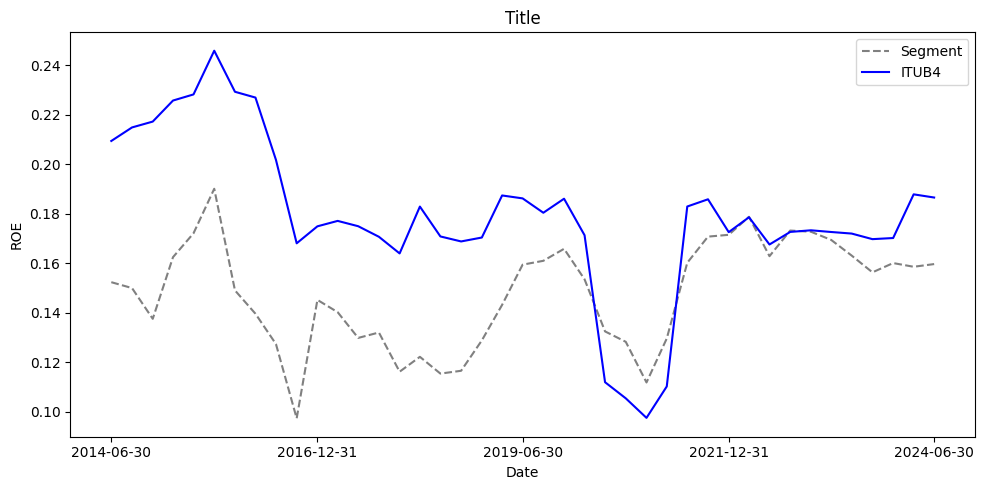

In [29]:
ticker="ITUB4"
# kpi="PL"
kpi="ROE"
# kpi="PROFIT"
# kpi="DIVIDEND_YIELD"

plot_historical_kpi(ticker, kpi)